# Create_sample_workflow notebook for NAAMES data from one day (20151107)

This notebook prepares plankton image data from an IFCB instrument for use in a machine learning test example. There are two data streams that are read in, a csv file containing one row of metadata for each image (~2 million total images), and a folder of plankton images in PNG format, with subfolders representing one IFCB sample each (each sample with 100s-1000s of images). The PNG data are converted to a 4d array and then used in a simple machine learning test case.

Function for image pre-processing `preprocess_input` is from E. Culhane \
Machine Learning model set-up and training code are from the example: https://keras.io/examples/vision/mnist_convnet/ 

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1Ds0GNR9uNKWBy49_sLARCbn7hIAY9lfh?authuser=1#scrollTo=FpZyQpk5IzGh)



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os 
from glob import glob
import cv2
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
DATA_PATH = '/gdrive/MyDrive/UTOPIA/Data/'
#NAAMES_DATA_PATH = 'gdrive/MyDrive/UTOPIA/Data/NAAMES_ml/'
SAMPLE_DATA_PATH = 'gdrive/MyDrive/UTOPIA/Data/D20151107/'

## buildPNGsName

This function is to create the name of the png and the folder path that will match each row of data in the "big" file of metadata and group information.

In [ ]:
# build a list of PNGs that match the rows of subsampled metadata from image-file-directory.csv

def buildPNGsName(imageid):
  '''
    Build a list of PNGs that match the rows of subsampled metadata
    Inputs
    ------
      imageid (str):
        example format: IFCB107D20151109T221417P00789
      
    Outputs
    -------
      png_name (str)
        name of the png and the folder it belongs to (relative path). 
        example format: D20151128T170950_IFCB107/IFCB107D20151128T170950P00079.png
        The folder name and the png name should match with exception of the underscore and the unique image id (PXXXXX)
  '''
  file_name = imageid + '.png'
  datetime = imageid[-22:-6]
  instrument_name = imageid[:-22]
  folder_name = datetime + '_' + instrument_name
  png_name = os.path.join(folder_name,file_name)
  return png_name

## Reading metadata image-by-row .csv file
Also remove rows in the file without metadata

In [ ]:
# this csv file contains ~2 million rows, one for each of the "manually" labeled images in the NAAMES dataset. 
csv_file = 'gdrive/MyDrive/UTOPIA/Data/image-file-directory.csv'

In [ ]:
# define dataframe of the entire csv file
df = pd.read_csv(csv_file)

In [ ]:
# add a column of the png path to the df datafram
df['png_path'] = df['id'].apply(lambda row : buildPNGsName(row))

In [ ]:
# check the first five rows 
df.head()

,file_name,class_raw,high_group,missing_high_group,id,lat,long,Area,Biovolume,ConvexArea,ConvexPerimeter,FeretDiameter,MajorAxisLength,MinorAxisLength,Perimeter,ESDA,ESDV,PA,ScatInt,FluoInt,ScatPeak,FluoPeak,NumberOfROIinTrigger,missing_meta_data,ESDA_exclude,excluded_1,set,binary_label,png_path
0,IFCB107D20151104T112022P00433_Unicellular.png,Unicellular,Other,False,IFCB107D20151104T112022P00433,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False,1,train,plankton,D20151104T112022_IFCB107/IFCB107D20151104T1120...
1,IFCB107D20151104T114135P00194_Unicellular.png,Unicellular,Other,False,IFCB107D20151104T114135P00194,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False,1,train,plankton,D20151104T114135_IFCB107/IFCB107D20151104T1141...
2,IFCB107D20151104T114135P00246_Unicellular.png,Unicellular,Other,False,IFCB107D20151104T114135P00246,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False,1,train,plankton,D20151104T114135_IFCB107/IFCB107D20151104T1141...
3,IFCB107D20151104T124515P00027_Unicellular.png,Unicellular,Other,False,IFCB107D20151104T124515P00027,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False,1,train,plankton,D20151104T124515_IFCB107/IFCB107D20151104T1245...
4,IFCB107D20151105T174918P00074_Dinophyceae.png,Dinophyceae,Dinoflagellate,False,IFCB107D20151105T174918P00074,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False,1,train,plankton,D20151105T174918_IFCB107/IFCB107D20151105T1749...


In [ ]:
# check the size of the dataframe
df.shape

(1998900, 29)

Remove rows in the dataframe without metadata (132,781 out of ~2 million)

In [ ]:
df.missing_meta_data == True

0           True
1           True
2           True
3           True
4           True
           ...  
1998895    False
1998896    False
1998897    False
1998898    False
1998899    False
Name: missing_meta_data, Length: 1998900, dtype: bool

In [ ]:
df[df.missing_meta_data == True].shape

(132781, 28)

In [ ]:
df_metadata = df[df.missing_meta_data == False]

In [ ]:
df_metadata.shape

(1866119, 28)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 <a list of 17 Text major ticklabel objects>)

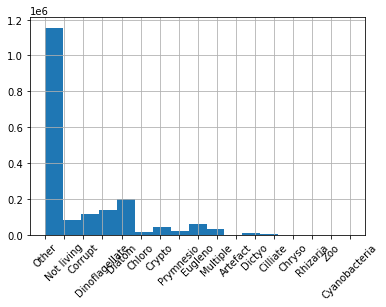

In [ ]:
# plot distribution of types (coarse taxonomic resolution; column named "high_group")
# need to define the number of bin to plot correctly
df_metadata.high_group.hist(bins=17) 
plt.xticks(rotation = 45)

In [ ]:
df_metadata.high_group.value_counts()

Other             1155984
Diatom             200173
Dinoflagellate     135342
Corrupt            113552
Not living          80816
Eugleno             61572
Crypto              42171
Multiple            29359
Prymnesio           20176
Chloro              11990
Dictyo              11228
Cilliate             3386
Artefact              179
Rhizaria              110
Cyanobacteria          48
Zoo                    20
Chryso                 13
Name: high_group, dtype: int64

In [ ]:
df_metadata.high_group.unique()

array(['Other', 'Not living', 'Corrupt', 'Dinoflagellate', 'Diatom',
       'Chloro', 'Crypto', 'Prymnesio', 'Eugleno', 'Multiple', 'Artefact',
       'Dictyo', 'Cilliate', 'Chryso', 'Rhizaria', 'Zoo', 'Cyanobacteria'],
      dtype=object)

### *Testing* to create PNG names from IDs in sample df

In [ ]:
id = sample_df.id[0]

NameError: ignored

In [ ]:
file_name = id + '.png'

This matching between png and filename id will only work with the current filename formatting 

folder format: D20180909T015237_IFCB107

*strip last 6 characters (e.g. P00000)

*date time is 16 characters

In [ ]:
datetime = id[-22:-6]

In [ ]:
instrument_name = id[:-22]

In [ ]:
folder_name = instrument_name + '_' + datetime

In [ ]:
os.path.join(folder_name,file_name)

### Select the top 11 groups with the most number of images

In [ ]:
list_groups = list(df_metadata.high_group.unique()[0:10])
list_groups.append('Dictyo')

In [ ]:
df_11groups = df_metadata.loc[df_metadata["high_group"].isin(list_groups)]

## Proportional sampling 

Sampling is proportional to the distribtion of the 11 groups; all groups do not have the same number of images

Sample_df is 1% of all images of the top 11 groups (out of 17), after the rows without metadata have been removed. 

In [ ]:
sample_df = df_11groups.groupby('high_group').apply(lambda x: x.sample(frac=0.01))

In [ ]:
sample_df.shape

(18625, 28)

In [ ]:
sample_df.high_group.value_counts()

Other             11560
Diatom             2002
Dinoflagellate     1353
Corrupt            1136
Not living          808
Eugleno             616
Crypto              422
Multiple            294
Prymnesio           202
Chloro              120
Dictyo              112
Name: high_group, dtype: int64

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 <a list of 11 Text major ticklabel objects>)

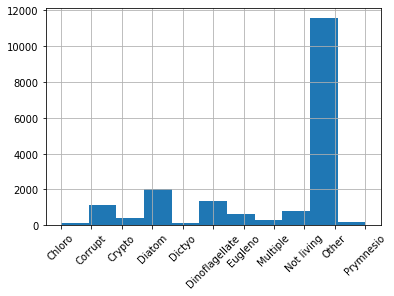

In [ ]:
sample_df.high_group.hist(bins=11)
plt.xticks(rotation = 45)

In [ ]:
sample_df.head()
len(sample_df)

18625

## Make the sample using the first rows of the file

This sample was used to try to reduce the file size and match to the early dates of NAAMES IFCB data

In [ ]:
df_begining = df_11groups.iloc[:10000]

In [ ]:
df_begining.tail()

,file_name,class_raw,high_group,missing_high_group,id,lat,long,Area,Biovolume,ConvexArea,ConvexPerimeter,FeretDiameter,MajorAxisLength,MinorAxisLength,Perimeter,ESDA,ESDV,PA,ScatInt,FluoInt,ScatPeak,FluoPeak,NumberOfROIinTrigger,missing_meta_data,ESDA_exclude,excluded_1,set,binary_label
14399,IFCB107D20151109T045036P00118_Unicellular.png,Unicellular,Other,False,IFCB107D20151109T045036P00118,43.999,-57.2347,32.525952,110.024483,41.522491,25.560196,16.029412,7.594388,5.832517,26.742059,6.435319,5.945160,0.822176,0.00241,0.00304,0.01103,0.13353,1.0,False,True,1,train,plankton
14400,IFCB107D20151109T045036P00122_Unicellular.png,Unicellular,Other,False,IFCB107D20151109T045036P00122,43.999,-57.2347,33.996540,124.911559,36.159170,22.385151,14.852941,7.026635,6.258711,21.714118,6.579190,6.202042,0.638716,0.00212,0.00310,0.01106,0.13786,1.0,False,True,1,train,plankton
14401,IFCB107D20151109T045036P00124_Unicellular.png,Unicellular,Other,False,IFCB107D20151109T045036P00124,43.999,-57.2347,32.439446,76.813315,37.110727,26.574625,17.205882,9.934640,4.525813,26.012059,6.426755,5.274071,0.801865,0.00182,-0.00097,0.01089,0.01173,1.0,False,True,1,train,plankton
14402,IFCB107D20151109T045036P00126_Unicellular.png,Unicellular,Other,False,IFCB107D20151109T045036P00126,43.999,-57.2347,31.487889,81.654821,39.446367,23.309459,13.382353,8.303241,5.295213,24.407059,6.331795,5.382628,0.775125,0.00234,0.00344,0.01103,0.12197,1.0,False,True,1,test,plankton
14403,IFCB107D20151109T045036P00127_Unicellular.png,Unicellular,Other,False,IFCB107D20151109T045036P00127,43.999,-57.2347,36.505190,141.517143,41.349481,23.958579,15.735294,7.568675,6.323076,24.287647,6.817613,6.465520,0.665320,0.00315,0.00866,0.06247,0.31384,1.0,False,True,1,train,plankton


In [ ]:
df_begining['png_path'] = df_begining['id'].apply(lambda row : buildPNGsName(row))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


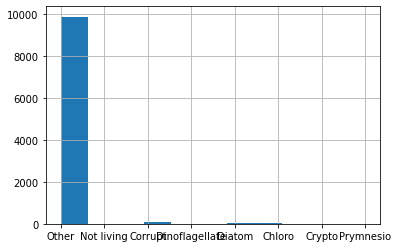

In [ ]:
df_begining.high_group.hist(bins=11)

In [ ]:
df_begining.high_group.value_counts()

Other             9871
Corrupt             74
Diatom              18
Chloro              17
Dinoflagellate      10
Not living           5
Prymnesio            3
Crypto               2
Name: high_group, dtype: int64

## Read PNG images from 20151107 from drive Data folder

Extracting PNG file names from the folders of PNGs (one folder per IFCB sample)

This test case uses just the PNGs from one day of samples: 20151107

In [ ]:
png_files_gdrive = glob('gdrive/MyDrive/UTOPIA/Data/D20151107/*/*.png')

In [ ]:
# all files from 20151107 should be 66,440
len(png_files_gdrive)

66440

Extracting PNG file names from the dataframe of metadata (one image per row)

In [ ]:
#df_begining_files = df_begining['png_path']

In [ ]:
# this test case uses the entire original dataframe, without any rows with missing data, etc, removed
#df_files = df['png_path']

In [ ]:
# create a dataframe with just the columns of png_path and high_group
df_files_labels = df[['png_path', 'high_group']]

In [ ]:
# add a column called full_path 
df_files_labels['full_path'] = df_files_labels['png_path'].apply(lambda row : os.path.join(SAMPLE_DATA_PATH, row))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df_files_labels

,png_path,high_group,full_path
0,D20151104T112022_IFCB107/IFCB107D20151104T1120...,Other,gdrive/MyDrive/UTOPIA/Data/D20151107/D20151104...
1,D20151104T114135_IFCB107/IFCB107D20151104T1141...,Other,gdrive/MyDrive/UTOPIA/Data/D20151107/D20151104...
2,D20151104T114135_IFCB107/IFCB107D20151104T1141...,Other,gdrive/MyDrive/UTOPIA/Data/D20151107/D20151104...
3,D20151104T124515_IFCB107/IFCB107D20151104T1245...,Other,gdrive/MyDrive/UTOPIA/Data/D20151107/D20151104...
4,D20151105T174918_IFCB107/IFCB107D20151105T1749...,Dinoflagellate,gdrive/MyDrive/UTOPIA/Data/D20151107/D20151105...
...,...,...,...
1998895,D20180412T010113_IFCB107/IFCB107D20180412T0101...,Dinoflagellate,gdrive/MyDrive/UTOPIA/Data/D20151107/D20180412...
1998896,D20180412T012434_IFCB107/IFCB107D20180412T0124...,Diatom,gdrive/MyDrive/UTOPIA/Data/D20151107/D20180412...
1998897,D20180412T012434_IFCB107/IFCB107D20180412T0124...,Diatom,gdrive/MyDrive/UTOPIA/Data/D20151107/D20180412...
1998898,D20180412T021117_IFCB107/IFCB107D20180412T0211...,Dinoflagellate,gdrive/MyDrive/UTOPIA/Data/D20151107/D20180412...


In [ ]:
# identify and define a dataframe based on the PNGs that are both in the list of files from 20151107, and that are in the dataframe made from the image-by-row csv file
df_sample_labels = df_files_labels[df_files_labels['full_path'].isin(png_files_gdrive)]

In [ ]:
df_sample_labels.shape

(34990, 3)

In [ ]:
# this is adding the full path to each .png name so now we have a list of all the .pngs we want to find in the NAAMES_ml folder
#df_begining_files_fullpath=[]
#for file_name in df_begining_files:
#   df_begining_files_fullpath.append(os.path.join(SAMPLE_DATA_PATH, file_name))

In [ ]:
# this is adding the full path to each .png name so now we have a list of all the .pngs
# this version is for the entire, original dataframe
#df_files_fullpath=[]
#for file_name in df_files:
#   df_files_fullpath.append(os.path.join(SAMPLE_DATA_PATH, file_name))

In [ ]:
# find matches between the list of names and .pngs in the D20151107 folder
#len(set(df_files_fullpath).intersection(png_files_gdrive))

In [ ]:
# create a dictionary to hold the original indices
#ind_dict = dict((k,i) for i,k in enumerate(df_files_fullpath))

In [ ]:
# build sets
#inter = set(df_files_fullpath).intersection(png_files_gdrive)

In [ ]:
# get a list of indices
#indices = [ ind_dict[x] for x in inter ]

In [ ]:
#png_list = set(df_files_fullpath).intersection(png_files_gdrive)

In [ ]:
#test_png = list(png_list)[0]
#test_png

In [ ]:
#df_files_fullpath[0]

In [ ]:
#plt.imshow(mpimg.imread(test_png))
#df.high_group[indices[0]]

## preprocess_input

This function prepares images for machine learning by square and padding them

In [ ]:
# COPIED from Emmett data_io_function_library:
def preprocess_input(image):
    fixed_size = 128
    image_size = image.shape[:2] 
    ratio = float(fixed_size)/max(image_size)
    new_size = tuple([int(x*ratio) for x in image_size])
    img = cv2.resize(image, (new_size[1], new_size[0]))
    delta_w = fixed_size - new_size[1]
    delta_h = fixed_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    color = [0, 0, 0]
    rescaled_image = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
    return(rescaled_image)

## Rescale/square images, and save as an array of arrays, for use in machine learning model

In [ ]:
df_sample_labels.shape

(10000, 3)

In [ ]:
# use only a subset of all PNGs to save computing time for now
df_sample_labels = df_sample_labels.iloc[:10000,]

In [ ]:
dataset = []
for filename, label in zip(df_sample_labels['full_path'],df_sample_labels['high_group']):
  #print(filename)
  image = cv2.imread(filename)
  rescaled_image = preprocess_input(image)
  dataset.append(rescaled_image)
  
  # plotting here is commented out otherwise too many figures are created
  #plt.figure()
  #plt.imshow(image)
  #plt.title(label)

In [ ]:
len(dataset)

NameError: ignored

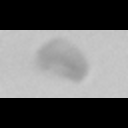

In [ ]:
Image.fromarray(dataset[10])

In [ ]:
# create a stacked set of arrays from the dataset
dataset_4d = np.array(dataset)

In [ ]:
type(dataset_4d)

numpy.ndarray

In [ ]:
dataset_4d.shape

(22182, 128, 128, 3)

## Use digit example ML model with dataset array containing RBG images

Define the x and y training and test sets

In [ ]:
# Model / data parameters
num_classes = 15
input_shape = (128, 128, 1)

In [ ]:
# this datafram has 3 columns: the name of the png path, the category label (high_group), and the full path of the png
# it is subset to only have rows that have png files matching the pngs that are found in the folder for 11/07
df_sample_labels.shape

(22182, 3)

In [ ]:
# need to get the list of image labels to accompany PNGs
image_labels = df_sample_labels.high_group

In [ ]:
image_labels

4359             Corrupt
4360               Other
4361               Other
4362             Corrupt
4363               Other
               ...      
795934    Dinoflagellate
795935             Other
795936             Other
795937             Other
795938             Other
Name: high_group, Length: 22182, dtype: object

In [ ]:
image_label_dummys = pd.get_dummies(image_labels)

In [ ]:
image_label_dummys

,Artefact,Chloro,Cilliate,Corrupt,Crypto,Diatom,Dictyo,Dinoflagellate,Eugleno,Multiple,Not living,Other,Prymnesio,Rhizaria,Zoo
4359,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4360,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4361,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4362,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4363,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795934,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
795935,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
795936,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
795937,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [ ]:
image_labels.value_counts()

Other             13762
Diatom             3160
Crypto             1684
Dinoflagellate     1197
Corrupt            1116
Not living          475
Dictyo              297
Multiple            169
Prymnesio           159
Cilliate             93
Chloro               55
Eugleno               8
Artefact              3
Rhizaria              2
Zoo                   2
Name: high_group, dtype: int64

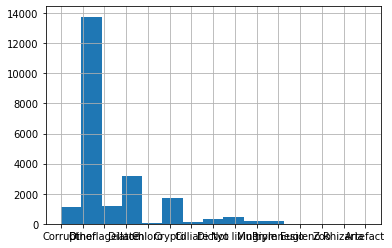

In [ ]:
image_labels.hist(bins=15)

In [ ]:
#train_test_cutoff = 200

In [ ]:
#x_train = dataset_3d[:train_test_cutoff,:,:]
#x_test = dataset_3d[train_test_cutoff:,:,:]

In [ ]:
dataset_4d.shape

(22182, 128, 128, 3)

In [ ]:
# convert to a grayscale and not rgb to test with digits example
dataset_3d = dataset_4d[:,:,:,0]

In [ ]:
dataset_3d.shape

(22182, 128, 128)

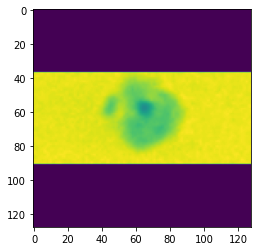

In [ ]:
plt.imshow(dataset_3d[0,])

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(dataset_3d, image_label_dummys, test_size=0.33, random_state=42)

In [ ]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(14861, 128, 128)
(7321, 128, 128)
(14861, 15)
(7321, 15)


In [ ]:
#y_train = image_label_dummys[:train_test_cutoff]
#y_test = image_label_dummys[train_test_cutoff:]

In [ ]:
print(y_train)

        Artefact  Chloro  Cilliate  Corrupt  ...  Other  Prymnesio  Rhizaria  Zoo
785455         0       0         0        0  ...      0          0         0    0
786248         0       0         0        0  ...      0          0         0    0
4411           0       0         0        0  ...      1          0         0    0
565495         0       0         0        0  ...      0          0         0    0
788166         0       0         0        0  ...      1          0         0    0
...          ...     ...       ...      ...  ...    ...        ...       ...  ...
785721         0       0         0        0  ...      0          0         0    0
795332         0       0         0        0  ...      1          0         0    0
565613         0       0         0        0  ...      1          0         0    0
5219           0       0         0        0  ...      1          0         0    0
789552         0       0         0        0  ...      0          0         0    0

[14861 rows x 1

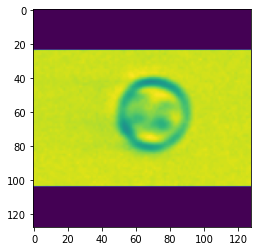

In [ ]:
plt.imshow(x_train[100,:,:])

In [ ]:
# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

x_train shape: (14861, 128, 128, 1)
14861 train samples
7321 test samples


In [ ]:
# convert class vectors to binary class matrices
#y_train = keras.utils.to_categorical(y_train, num_classes)
#y_test = keras.utils.to_categorical(y_test, num_classes)

In [ ]:
x_train.shape

(14861, 128, 128, 1)

In [ ]:
y_train.shape

(14861, 15)

In [ ]:
type(y_train)

pandas.core.frame.DataFrame

In [ ]:
np.array(y_train)
y_train.shape

(14861, 15)

### Build the model

In [ ]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 57600)             0         
                                                                 
 dropout_2 (Dropout)         (None, 57600)            

### Train the model

In [ ]:
x_train.shape

(14861, 128, 128, 1)

In [ ]:
y_train.shape

(14861, 15)

In [ ]:
batch_size = 128
epochs = 15

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/15
105/105 [==============================] - 256s 2s/step - loss: 1.0973 - accuracy: 0.6638 - val_loss: 0.8908 - val_accuracy: 0.7169
Epoch 2/15
105/105 [==============================] - 251s 2s/step - loss: 0.8455 - accuracy: 0.7334 - val_loss: 0.7856 - val_accuracy: 0.7471
Epoch 3/15
105/105 [==============================] - 251s 2s/step - loss: 0.7541 - accuracy: 0.7582 - val_loss: 0.7100 - val_accuracy: 0.7754
Epoch 4/15
105/105 [==============================] - 251s 2s/step - loss: 0.7094 - accuracy: 0.7706 - val_loss: 0.6938 - val_accuracy: 0.7734
Epoch 5/15
105/105 [==============================] - 249s 2s/step - loss: 0.6760 - accuracy: 0.7798 - val_loss: 0.6646 - val_accuracy: 0.7841
Epoch 6/15
105/105 [==============================] - 253s 2s/step - loss: 0.6464 - accuracy: 0.7918 - val_loss: 0.6520 - val_accuracy: 0.7956
Epoch 7/15
 42/105 [===========>..................] - ETA: 2:28 - loss: 0.6212 - accuracy: 0.7967

KeyboardInterrupt: ignored

### Evaluate the trained model

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.18661648035049438
Test accuracy: 0.9599999785423279
